# Mini-Project #4 (Part C)

Student Name: **Subhadyuti Sahoo**
<br>
Course: **Adv Topics in Machine Learning**

### Importing Necessary Libraries, Modules and Classes

In [1]:
import os
import time
import datetime
import sys
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import statistics
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU, PReLU, Dense, LSTM 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import losses
import warnings
from numpy.random import seed
tf.random.set_seed(1234)
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Importing the Dataset

In [2]:
# Forming the pandas dataframe
# entireDataSet = pd.read_csv('/content/drive/My Drive/AdvTopicsInML/NVDA.csv')   # for Google Colab
entireDataSet = pd.read_csv('NVDA.csv')   # for Jupyter Notebook

# Displaying the pandas dataFrame
display(entireDataSet)  

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-22,1.750000,1.953125,1.552083,1.640625,1.508412,67867200
1,1999-01-25,1.770833,1.833333,1.640625,1.812500,1.666436,12762000
2,1999-01-26,1.833333,1.869792,1.645833,1.671875,1.537143,8580000
3,1999-01-27,1.677083,1.718750,1.583333,1.666667,1.532354,6109200
4,1999-01-28,1.666667,1.677083,1.651042,1.661458,1.527566,5688000
...,...,...,...,...,...,...,...
5561,2021-03-01,555.000000,557.000000,542.130005,553.669983,553.669983,8802500
5562,2021-03-02,556.000000,556.820007,535.840027,536.250000,536.250000,6585500
5563,2021-03-03,537.049988,538.059998,511.950012,512.190002,512.190002,9408000
5564,2021-03-04,512.030029,519.000000,483.350006,494.809998,494.809998,14292400


<a id='Description'></a>
<div class=" alert alert-warning">
    <b>Description.</b>
 
Same as Mini-project #3, this project will use the historic adjusted closing price data of NVDA as the training/test data and build an artificial neural network (ANN) to predict the adjusted closing price in the future. We will only use the adjusted closing price. We will $60:20:20$ split the data for training, validation and test, reserving the most recent $20\%$ data for test, as though we had traveled back in time to September $30, 2016$. We will try to see if different activation function or LSTM can lead to better prediction with higher
accuracy.
    
</div>

### Extracting The Working Dataset

In [3]:
dSet = pd.DataFrame(entireDataSet['Adj Close'], columns=['Adj Close'])   # Working with only the Adjusted Closing Price

### Checking for Missing Values (if any)

In [4]:
# Checking if there are missing values in the workign dataset
result = (dSet.isna().values.any()) or (dSet.isnull().values.any())
if (result == True):
    n_missing_values = dSet.isna().sum().sum() + dSet.isnull().sum().sum()

# Displaying if there are any missing values in dataFrame
print('--- Checking for Missing Values ---')
print('Q. Are there any missing values in the dataset?')   
if (result == True):
    print('A. Yes')
    print('Q. How many?')
    print('A. ', n_missing_values)
else:
    print('A. No') 
print('-----------------------------------')
print('\n')

--- Checking for Missing Values ---
Q. Are there any missing values in the dataset?
A. No
-----------------------------------




### Splitting the Working Dataset

In [5]:
# Splitting the data after September 30, 2016
dates = entireDataSet['Date'].to_numpy()
trainval_indices = np.where(dates < '2016-10-01')
trainval_index_start = trainval_indices[0][0]
trainval_index_end = trainval_indices[0][-1]

# Converting the working dataset to a numpy array 
dSet = dSet.values
dSet = dSet.astype('float32')  # Converting to Tensor Form

# Preprocessing the dataset
scaler = MinMaxScaler(feature_range=(0, 1))  # Forming an instance of MinMaxScaler class  
dSet = scaler.fit_transform(dSet)  # Scaling the dataset

# Splitting the working dataset into train, val and test datasets
n = (0.6 * len(dSet)) / trainval_index_end
trainDataSet = dSet[:int(n*trainval_index_end)]
valDataSet = dSet[int(n*trainval_index_end):trainval_index_end+1]
testDataSet = dSet[trainval_index_end+1:]
tempTestDates = entireDataSet['Date'][trainval_index_end+1:]

### User-Defined Function to Form Training, Validation and Test Datasets Depending Upon Prior Days

In [6]:
def get_refurbished_datasets(dataset, prior_days):
    """
    Returns the reconfigured datasets for 'n' prior days
  
    Args: 
      dataset (vector, shape = [n, 1]): the column of interest from the entire, bigger dataset
      prior_days (int): the number of prior days for which the column of interest needs to be reconfigured
    """
    
    # Forming empty lists to store data
    X_, y_ = [], []
    
    # Forming the reconfigured datasets for 'n' prior days
    for i in range(len(dataset)-prior_days):
        a = dataset[i:(i + prior_days), 0]
        X_.append(a)
        y_.append(dataset[i + prior_days, 0])
        
    # Returning the reconfigured datasets
    return np.array(X_), np.array(y_)

### Creating A User-Defined Function In Order To Compile and Train Different ANN Models 

In [7]:
def compile_and_fit(model, trainFeatures, trainLabels, valFeatures,
                    valLabels, batchSize, n_epochs, verBose):
    """
    Returns a compiled model
  
    Args:
      model (keras sequential model): the filled model
      trainFeatures (array, shape = [m,n]): the training dataset features
      trainLabels (vector, shape = [m,1]): the training dataset labels
      valFeatures (array, shape = [p, n]): the validation dataset features
      valLabels (vector, shape = [p,1]): the validation dataset labels
      batchSize (int): the max no. of batches to be used for compiling the model
      n_epochs (int): the max no. iterations for simulating the model
    """

    # Compiling the model
    model.compile(# Objective (Loss) Function
                  loss = 'mean_squared_error',  # meanSquaredError

                  # Optimizer
                  optimizer = 'adam'
                 )
  
    # Training the model
    history = model.fit(x = trainFeatures,
                        y = trainLabels,
                        batch_size = batchSize, 
                        epochs = n_epochs,
                        validation_data = (valFeatures, valLabels),
                        verbose = verBose)
  
    # Returning the compiled model
    return history 

### Forming the Working Datasets for Training, Validation and Test for 10 Prior Days

In [8]:
# Mentioning the prior days
prior_days = 10

# Forming the final training dataset
X_train, y_train = get_refurbished_datasets(dataset=trainDataSet, prior_days=prior_days)

# Forming the final validation dataset
X_val, y_val = get_refurbished_datasets(dataset=valDataSet, prior_days=prior_days)

# Forming the final test dataset
X_test, y_test = get_refurbished_datasets(dataset=testDataSet, prior_days=prior_days)

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset (' + str(prior_days) + ' Prior Days) ---')
print(f'Training Features Dataset Shape: {X_train.shape}')
print(f'Training Labels Dataset Shape: {y_train.shape}')
print(f'Validation Features Dataset Shape: {X_val.shape}')
print(f'Validation Labels Dataset Shape: {y_val.shape}')
print(f'Test Features Dataset Shape: {X_test.shape}')
print(f'Test Labels Dataset Shape: {y_test.shape}')
print('----------------------------------------------')

--- Shapes of Each Dataset (10 Prior Days) ---
Training Features Dataset Shape: (3329, 10)
Training Labels Dataset Shape: (3329,)
Validation Features Dataset Shape: (1104, 10)
Validation Labels Dataset Shape: (1104,)
Test Features Dataset Shape: (1103, 10)
Test Labels Dataset Shape: (1103,)
----------------------------------------------


<a id='QuestionC'></a>
<div class=" alert alert-warning">
    <b>Question.</b>
 
Does any preprocessing on the input data help with your models in (a) and (b)? Describe the data preprocessing technique you choose to use and its rationale. 

</div>

<a id='AnswerQA'></a>
<div class=" alert alert-info">
    <b>Answer.</b>

$\textbf{Preprocessing Technique}$: All the features were transformed to a range between $\texttt{0}$ and $\texttt{1}$ by using $\textsf{MinMaxScaler}$ from $\textsf{sklearn.preprocessing}$. This technique was chosen because it standardizes the data. 
    
<br>
$\textbf{Conclusion}$: 

- Preprocessing the dataset for $\texttt{Part (a)}$ $\underline{does}$ $\underline{not}$ provide better results for the best $\texttt{ANN}$ model as the MSE scores for both validation and test datasets <font color='red'>increase</font> significantly
    
- Preprocessing the dataset for $\texttt{Part (b)}$ $\underline{does}$ provide better results for the best $\texttt{LSTM}$ model as the MSE scores for both validation and test datasets <font color='green'>decrease</font> significantly

    
</div>

### The Best ANN Model from Part (A) (1 Hidden Layer with 80 Hidden Neurons, Softplus Activation Function, 10 Prior Days)

In [9]:
# Building and Compiling The Model
model10801softplus = Sequential() 
model10801softplus.add(Dense(units=80, activation='softplus', input_dim=X_train.shape[1]))
model10801softplus.add(Dense(units=1))
model10801softplus.summary() 
history10801softplus = compile_and_fit(model=model10801softplus, trainFeatures=X_train, trainLabels=y_train, 
                                       valFeatures=X_val, valLabels=y_val, batchSize=32, n_epochs=20, verBose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                880       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 81        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
105/105 [==============================] - 1s 3ms/step - loss: 0.1780 - val_loss: 0.0019
Epoch 2/20
105/105 [==============================] - 0s 2ms/step - loss: 3.2493e-04 - val_loss: 0.0013
Epoch 3/20
105/105 [==============================] - 0s 2ms/step - loss: 1.9789e-04 - val_loss: 6.5967e-04
Epoch 4/20
105/105 [==============================] - 0s 2ms/step - loss: 1.0517e-04 - val_loss: 3.1481e-04
Epoch 5/20
105/105 [==============================] - 0s 2ms/step - loss: 4.8616e-05 - val_loss: 1.4

In [10]:
# Estimating the predictions for training, validation and test datasets
yTrainPredSoftPlus = model10801softplus.predict(X_train)
yValPredSoftPlus = model10801softplus.predict(X_val)
yTestPredSoftPlus = model10801softplus.predict(X_test)

In [11]:
# Inverting training, validation and test datasets
y_train_softplus = scaler.inverse_transform(y_train.reshape(-1,1))
y_val_softplus = scaler.inverse_transform(y_val.reshape(-1,1))
y_test_softplus = scaler.inverse_transform(y_test.reshape(-1,1))

# Inverting the predictions for training, validation and test datasets
yTrainPredSoftPlus = scaler.inverse_transform(yTrainPredSoftPlus)
yValPredSoftPlus = scaler.inverse_transform(yValPredSoftPlus)
yTestPredSoftPlus = scaler.inverse_transform(yTestPredSoftPlus)

In [12]:
# Computing the MSE scores for training, validation and test datasets
trainMSESoftPlus = mean_squared_error(y_train_softplus, yTrainPredSoftPlus)
valMSESoftPlus = mean_squared_error(y_val_softplus, yValPredSoftPlus)
testMSESoftPlus = mean_squared_error(y_test_softplus, yTestPredSoftPlus)

# Print the MSE scores for training and validation datasets
print('--- MSE Scores for the Best ANN Model from Part (A) (Preprocessed) ---')
print('Train Score: %.2f MSE' % (trainMSESoftPlus))
print('Val Score: %.2f MSE' % (valMSESoftPlus))
print('Test Score: %.2f MSE' % (testMSESoftPlus))
print('----------------------------------------------------------------------')

--- MSE Scores for the Best ANN Model from Part (A) (Preprocessed) ---
Train Score: 1.03 MSE
Val Score: 1.14 MSE
Test Score: 319.40 MSE
----------------------------------------------------------------------


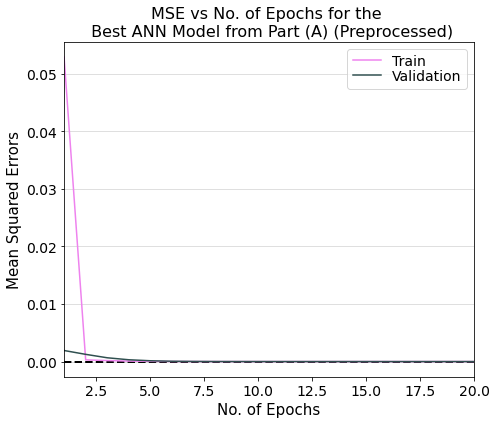

In [13]:
# Plotting the training and validation MSE scores v/s Epochs
titleString = "MSE vs No. of Epochs for the \n Best ANN Model from Part (A) (Preprocessed)"
trainMSE = np.asarray(history10801softplus.history['loss']).reshape(-1,1) 
valMSE = np.asarray(history10801softplus.history['val_loss']).reshape(-1,1)
horzLine = np.linspace(1, 20)
horzLineData = np.array([0.00 for i in range(len(horzLine))])
fig, ax = plt.subplots(figsize=(7,6)) 
ax.plot(horzLine, horzLineData, 'k--', LineWidth=2)
ax.plot(range(1, 21), trainMSE, color='violet', label='Train')   
ax.plot(range(1, 21), valMSE, color='darkslategray', label='Validation')   
ax.set_title(titleString, fontsize=16)  
ax.set_ylabel('Mean Squared Errors', fontsize=15)   
ax.set_xlabel('No. of Epochs', fontsize=15)  
ax.set_xlim(left=1, right=20)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(axis='y', linestyle='-', alpha=0.5)
plt.legend(prop={'size': 14}, ncol=1, labelspacing=0.05, loc='upper right')   
plt.tight_layout()
plt.show()

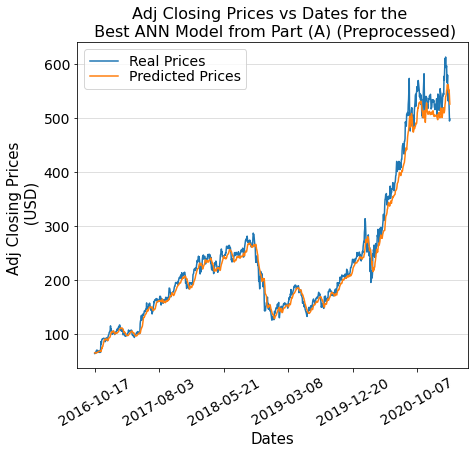

In [14]:
# Plotting the Real and Predicted Adjusted Closing Prices for the Best ANN Model
testDates = tempTestDates.iloc[prior_days:]
dFrame = pd.DataFrame({'Date': testDates, 
                       'Real Prices': np.asarray(y_test_softplus).astype(np.float64).flatten(), 
                       'Predicted Prices': yTestPredSoftPlus.flatten()})
titleString = "Adj Closing Prices vs Dates for the \n Best ANN Model from Part (A) (Preprocessed)"
fig, ax = plt.subplots(figsize=(7,6)) 
dFrame.plot(ax = ax, 
            x = "Date", 
            y = ["Real Prices", "Predicted Prices"],
            rot = 30)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title(titleString, fontsize=16) 
ax.set_xlabel('Dates', fontsize=15)
ax.set_ylabel('Adj Closing Prices \n (USD)', fontsize=15)
ax.grid(axis='y', linestyle='-', alpha=0.5)
ax.legend(prop={'size': 14}, ncol=1, labelspacing=0.05, loc='upper left')
plt.show() 

### The Best ANN Model from Part (B) (LSTM, 10 Prior Days)

In [15]:
# Reshaping Feature Matrices
X_train_10_wm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))  # Training dataset
X_val_10_wm = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))  # Training dataset
X_test_10_wm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))  # Training dataset

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset [samples, time steps, features] (' + str(prior_days) + ' Prior Days, Window Method) ---')
print(f'Training Features Dataset Shape: {X_train_10_wm.shape}')
print(f'Training Labels Dataset Shape: {y_train.shape}')
print(f'Validation Features Dataset Shape: {X_val_10_wm.shape}')
print(f'Validation Labels Dataset Shape: {y_val.shape}')
print(f'Test Features Dataset Shape: {X_test_10_wm.shape}')
print(f'Test Labels Dataset Shape: {y_test.shape}')
print('---------------------------------------------------------------------------------------------')

--- Shapes of Each Dataset [samples, time steps, features] (10 Prior Days, Window Method) ---
Training Features Dataset Shape: (3329, 1, 10)
Training Labels Dataset Shape: (3329,)
Validation Features Dataset Shape: (1104, 1, 10)
Validation Labels Dataset Shape: (1104,)
Test Features Dataset Shape: (1103, 1, 10)
Test Labels Dataset Shape: (1103,)
---------------------------------------------------------------------------------------------


In [16]:
# Building and Compiling The Model
modelLSTM = Sequential()
modelLSTM.add(LSTM(units=80, input_shape=(1, prior_days)))
modelLSTM.add(Dense(units=1))
modelLSTM.compile(loss='mean_squared_error', optimizer='adam')
modelLSTM.summary() 
historyLSTM = compile_and_fit(model=modelLSTM, trainFeatures=X_train_10_wm, trainLabels=y_train, 
                              valFeatures=X_val_10_wm, valLabels=y_val, batchSize=32, n_epochs=40, verBose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 80)                29120     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 81        
Total params: 29,201
Trainable params: 29,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
105/105 [==============================] - 10s 6ms/step - loss: 5.8110e-05 - val_loss: 2.5560e-06
Epoch 2/40
105/105 [==============================] - 0s 3ms/step - loss: 2.2190e-06 - val_loss: 3.0638e-06
Epoch 3/40
105/105 [==============================] - 0s 3ms/step - loss: 2.1884e-06 - val_loss: 3.2504e-06
Epoch 4/40
105/105 [==============================] - 0s 3ms/step - loss: 2.2286e-06 - val_loss: 3.2407e-06
Epoch 5/40
105/105 [==============================] - 0s 3ms/step - loss: 1.975

In [17]:
# Estimating the predictions for training, validation and test datasets
yTrainPredLSTM = modelLSTM.predict(X_train_10_wm)
yValPredLSTM = modelLSTM.predict(X_val_10_wm)
yTestPredLSTM = modelLSTM.predict(X_test_10_wm)

In [18]:
# Inverting training, validation and test datasets
y_train_LSTM = scaler.inverse_transform([y_train])
y_val_LSTM = scaler.inverse_transform([y_val])
y_test_LSTM = scaler.inverse_transform([y_test])

# Inverting the predictions for training, validation and test datasets
yTrainPredLSTM = scaler.inverse_transform(yTrainPredLSTM)
yValPredLSTM = scaler.inverse_transform(yValPredLSTM)
yTestPredLSTM = scaler.inverse_transform(yTestPredLSTM)

In [25]:
# Computing the MSE scores for training, validation and test datasets
trainMSELSTM = mean_squared_error(y_train_LSTM[0], yTrainPredLSTM[:,0])
valMSELSTM = mean_squared_error(y_val_LSTM[0], yValPredLSTM[:,0])
testMSELSTM = mean_squared_error(y_test_LSTM[0], yTestPredLSTM[:,0])

# Print the MSE scores for training and validation datasets
print('-- MSE Scores for the Best LSTM Model from Part (B) (Preprocessed) --')
print('Train Score: %.2f MSE' % (trainMSELSTM))
print('Val Score: %.2f MSE' % (valMSELSTM))
print('Test Score: %.2f MSE' % (testMSELSTM))
print('---------------------------------------------------------------------')

-- MSE Scores for the Best LSTM Model from Part (B) (Preprocessed) --
Train Score: 0.31 MSE
Val Score: 0.33 MSE
Test Score: 88.88 MSE
---------------------------------------------------------------------


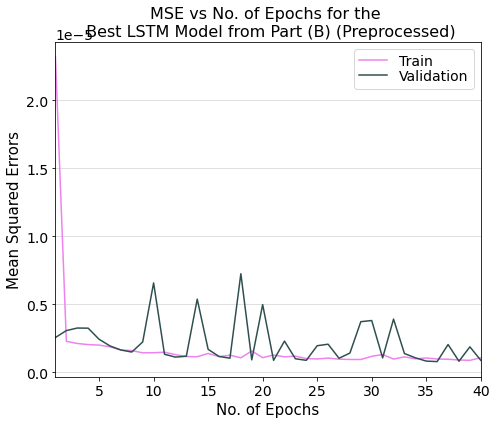

In [23]:
# Plotting the training and validation MSE scores v/s Epochs
n_epochs = 40
titleString = "MSE vs No. of Epochs for the \n Best LSTM Model from Part (B) (Preprocessed)"
trainMSE = np.asarray(historyLSTM.history['loss']).reshape(-1,1) 
valMSE = np.asarray(historyLSTM.history['val_loss']).reshape(-1,1)
# horzLine = np.linspace(1, 20)
# horzLineData = np.array([0.00 for i in range(len(horzLine))])
fig, ax = plt.subplots(figsize=(7,6)) 
# ax.plot(horzLine, horzLineData, 'k--', LineWidth=2)
ax.plot(range(1, (n_epochs+1)), trainMSE, color='violet', label='Train')   
ax.plot(range(1, (n_epochs+1)), valMSE, color='darkslategray', label='Validation')   
ax.set_title(titleString, fontsize=16)  
ax.set_ylabel('Mean Squared Errors', fontsize=15)   
ax.set_xlabel('No. of Epochs', fontsize=15)  
ax.set_xlim(left=1, right=n_epochs)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
t = ax.yaxis.get_offset_text()
t.set_size(14)
ax.grid(axis='y', linestyle='-', alpha=0.5)
plt.legend(prop={'size': 14}, ncol=1, labelspacing=0.05, loc='upper right')   
plt.tight_layout()
plt.show()

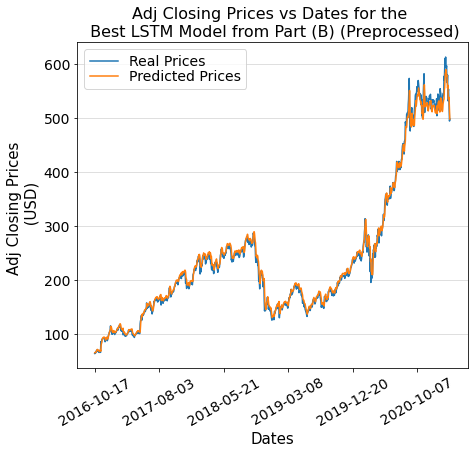

In [24]:
# Plotting the Real and Predicted Adjusted Closing Prices for the Best ANN Model
testDates = tempTestDates.iloc[prior_days:]
dFrame = pd.DataFrame({'Date': testDates, 
                       'Real Prices': np.asarray(y_test_LSTM[0]).astype(np.float64).flatten(), 
                       'Predicted Prices': yTestPredLSTM[:,0].flatten()})
titleString = "Adj Closing Prices vs Dates for the \n Best LSTM Model from Part (B) (Preprocessed)"
fig, ax = plt.subplots(figsize=(7,6)) 
dFrame.plot(ax = ax, 
            x = "Date", 
            y = ["Real Prices", "Predicted Prices"],
            rot = 30)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title(titleString, fontsize=16) 
ax.set_xlabel('Dates', fontsize=15)
ax.set_ylabel('Adj Closing Prices \n (USD)', fontsize=15)
ax.grid(axis='y', linestyle='-', alpha=0.5)
ax.legend(prop={'size': 14}, ncol=1, labelspacing=0.05, loc='upper left')
plt.show() 